## Example of the basic bosk usage

In this example we will see how to implement classic deep forest using bosk predefined arsenal.

In [1]:
from bosk.pipeline.base import BasePipeline, Connection
from bosk.painter.graphviz import GraphvizPainter
from bosk.executor.recursive import RecursiveExecutor
from bosk.stages import Stage
from bosk.block.zoo.models.classification import RFCBlock, ETCBlock
from bosk.block.zoo.data_conversion import ConcatBlock, AverageBlock, ArgmaxBlock, StackBlock
from bosk.block.zoo.input_plugs import InputBlock, TargetInputBlock
from bosk.block.zoo.metrics import RocAucBlock
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from IPython.display import Image

In [2]:
random_state = 42
n_estimators = 7
EXEC_CLS = RecursiveExecutor


def get_plain_dataset():
    all_X, all_y = make_moons(noise=1, random_state=random_state)
    train_X, test_X, train_y, test_y = train_test_split(
        all_X, all_y, test_size=0.2, random_state=random_state)
    return train_X, test_X, train_y, test_y


def get_image_dataset():
    digits = load_digits()
    all_X = digits.data
    all_y = digits.target
    train_X, test_X, train_y, test_y = train_test_split(
        all_X, all_y, test_size=0.2, random_state=random_state)
    return train_X, test_X, train_y, test_y


def draw_pipeline(pipeline: BasePipeline, rankdir: str = 'LR'):
    GraphvizPainter(figure_dpi=100, figure_rankdir=rankdir).from_pipeline(pipeline).render('deep_forest.jpeg')
    display(Image(filename='deep_forest.jpeg'))

Firstly we will use the functional API to implement classical deep forest with two layers. This instrument makes connections creating process concise. We simply create blocks and in the call method we specify which slots of the block we want to connect with other blocks. Argument names correspond to the slots, values indicate, which block we want to use as the input for the slot. Pay attention that in this example all the blocks have only one output slot, so we don't have to specify what output slot to use.

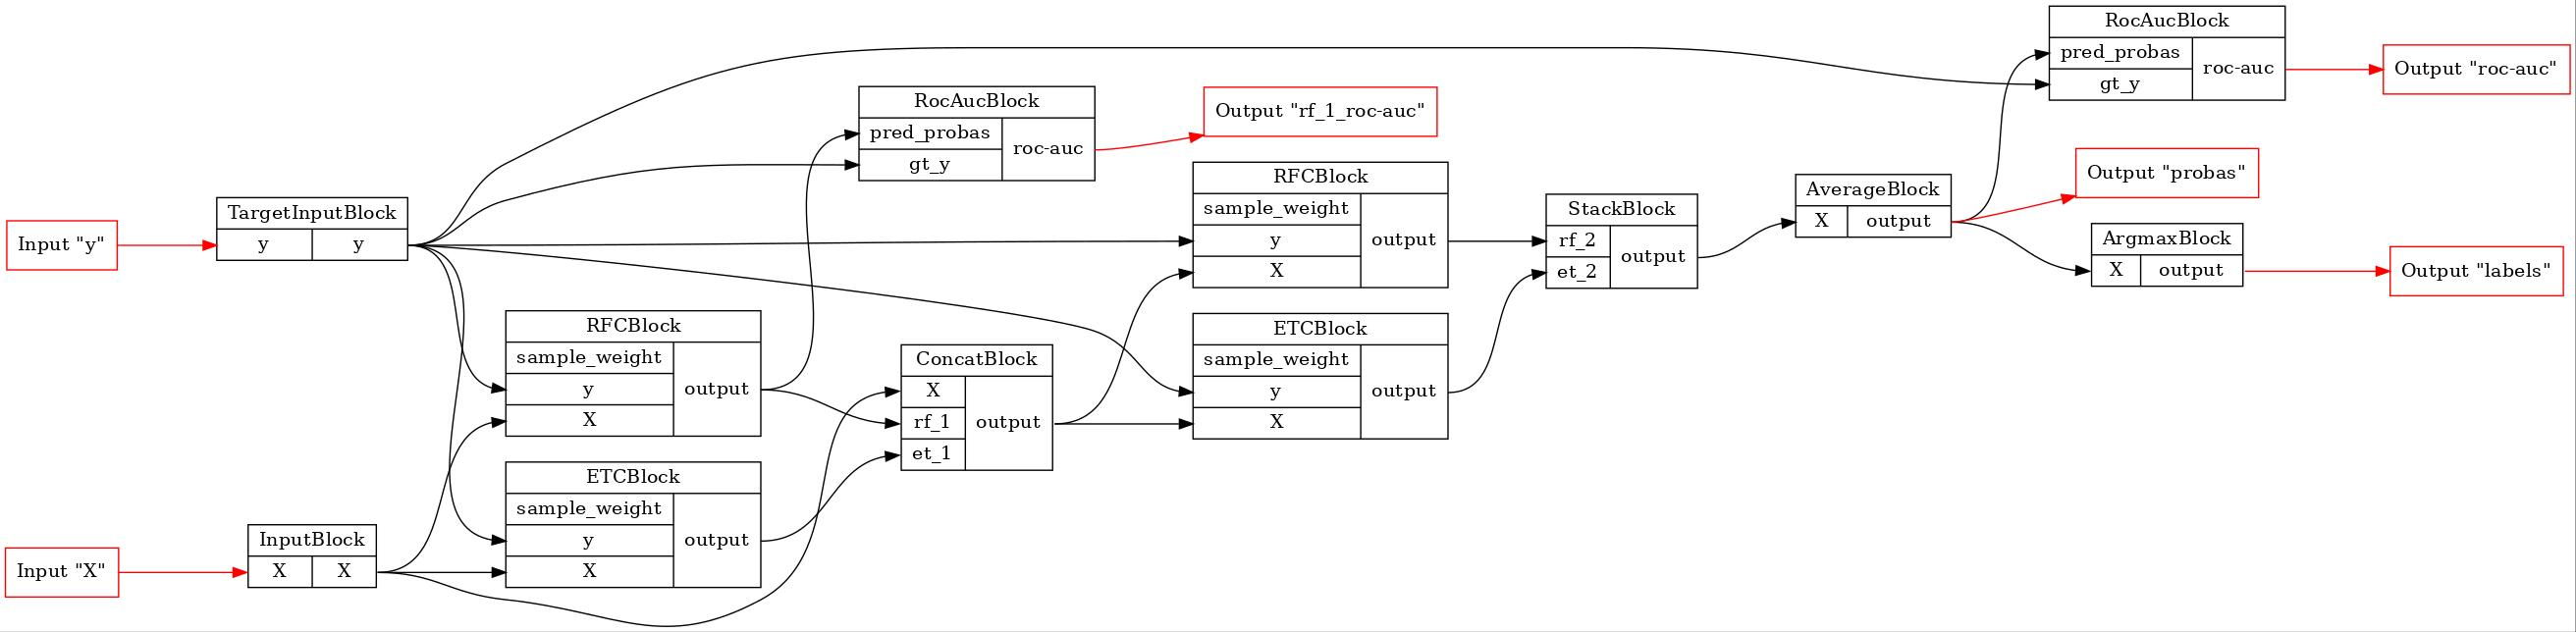

In [3]:
# firstly we must obtain the functional builder object
b = FunctionalPipelineBuilder()
# that we do as it was described above
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_estimators)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_estimators)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_estimators)(X=concat_1, y=y)
et_2 = b.ETC(n_estimators=n_estimators)(X=concat_1, y=y)
stack = b.Stack(['rf_2', 'et_2'], axis=1)(rf_2=rf_2, et_2=et_2)
average = b.Average(axis=1)(X=stack)
argmax = b.Argmax(axis=1)(X=average)
rf_1_roc_auc = b.RocAuc()(gt_y=y, pred_probas=rf_1)
roc_auc = b.RocAuc()(gt_y=y, pred_probas=average)
pipeline = b.build(
    {'X': X, 'y': y},
    {'labels': argmax, 'probas': average, 'rf_1_roc-auc': rf_1_roc_auc, 'roc-auc': roc_auc}
)
pipeline.set_random_state(random_state)
# let's draw our pipeline to see, what we've got
draw_pipeline(pipeline)
# as we can see, the code became much shorter
# with the same result

In [4]:
# to end this example, let's do the same tests as above
# and ensure ourselves that the results are the same
fit_executor = EXEC_CLS(
    pipeline,
    stage=Stage.FIT,
    inputs=['X', 'y'],
    outputs=['probas', 'rf_1_roc-auc', 'roc-auc']
)
transform_executor = EXEC_CLS(
    pipeline,
    stage=Stage.TRANSFORM,
    inputs=['X'],
    outputs=['probas', 'labels']
)
train_X, test_X, train_y, test_y = get_plain_dataset()
fit_result = fit_executor({'X': train_X, 'y': train_y}).numpy()
train_result = transform_executor({'X': train_X}).numpy()
print("Fit probas == probas on train:", np.allclose(fit_result['probas'], train_result['probas']))
print("Train ROC-AUC:", roc_auc_score(train_y, train_result['probas'][:, 1]))
print(
    "Train ROC-AUC calculated by fit executor:",
    fit_result['roc-auc']
)
print(
    "Train ROC-AUC for RF_1:",
    fit_result['rf_1_roc-auc']
)
test_result = transform_executor({'X': test_X}).numpy()
print("Test ROC-AUC:", roc_auc_score(test_y, test_result['probas'][:, 1]))

Fit probas == probas on train: True
Train ROC-AUC: 1.0
Train ROC-AUC calculated by fit executor: 1.0
Train ROC-AUC for RF_1: 0.9892676767676768
Test ROC-AUC: 0.8571428571428572


### A note about pipelines

Pipeline is a computational graph in the bosk framework. Currently our framework has only one pipeline type: `BasePipeline`. `BasePipeline` is a dataclass that contatins graph nodes (i.e. compute blocks) and edges (i.e. connections). As the computational graph is directed and acyclic, `BasePipeline` also contains static information about inputs and outputs (their names and location). Nevertheless there wasn't implemented a check for the injection, we strongly recommend to mark inputs and outputs correctly: different slots should correspond to the different names.

To route a data across a pipeline we decided to add the *slots* concept. Each block has list of input and output slots with the unique (for the particular block) names, where the data can be routed. Usually the output slot is one, but it's not a rule. Thus the bosk pipeline can be described either in terms of blocks or - of slots, as each slot has a link to his parent block. However, to build the pipeline you must operate only in terms of slots and route a data from an output block slot to an input one.

### A note about executors

Executor is a manager that performes a computational graph (i.e. pipeline) processing. One pipeline can behave differently depending on the computational stage. For example, to fit the classical deep forest model, we need to pass predictors and outcomes, but after the fit process we only need to pass new predictors. For each of those stages user should create individual executor. 

Pipelines can be executed in serial or parallel mode (in terms of number of compute blocks executed concurently; each block can require several workers in both cases). We recommend to run pipelines in serial mode with giving as much workers for each block as it's possible and use parallel pipeline execution only if you have several devices for different blocks processing (for example, some blocks in the pipeline run on the cpu and some - on the gpu). For serial execution we suggest to use `TopologicalExecutor`, for parallel - `GreedyParallelExecutor`. In this example we will use `RecursiveExecutor` as the built pipelines will be simple.

Functional API is the convenient way to build models in bosk. However, there is a way to define the computational graph manually. Let's implement the same deep forest with this technique.

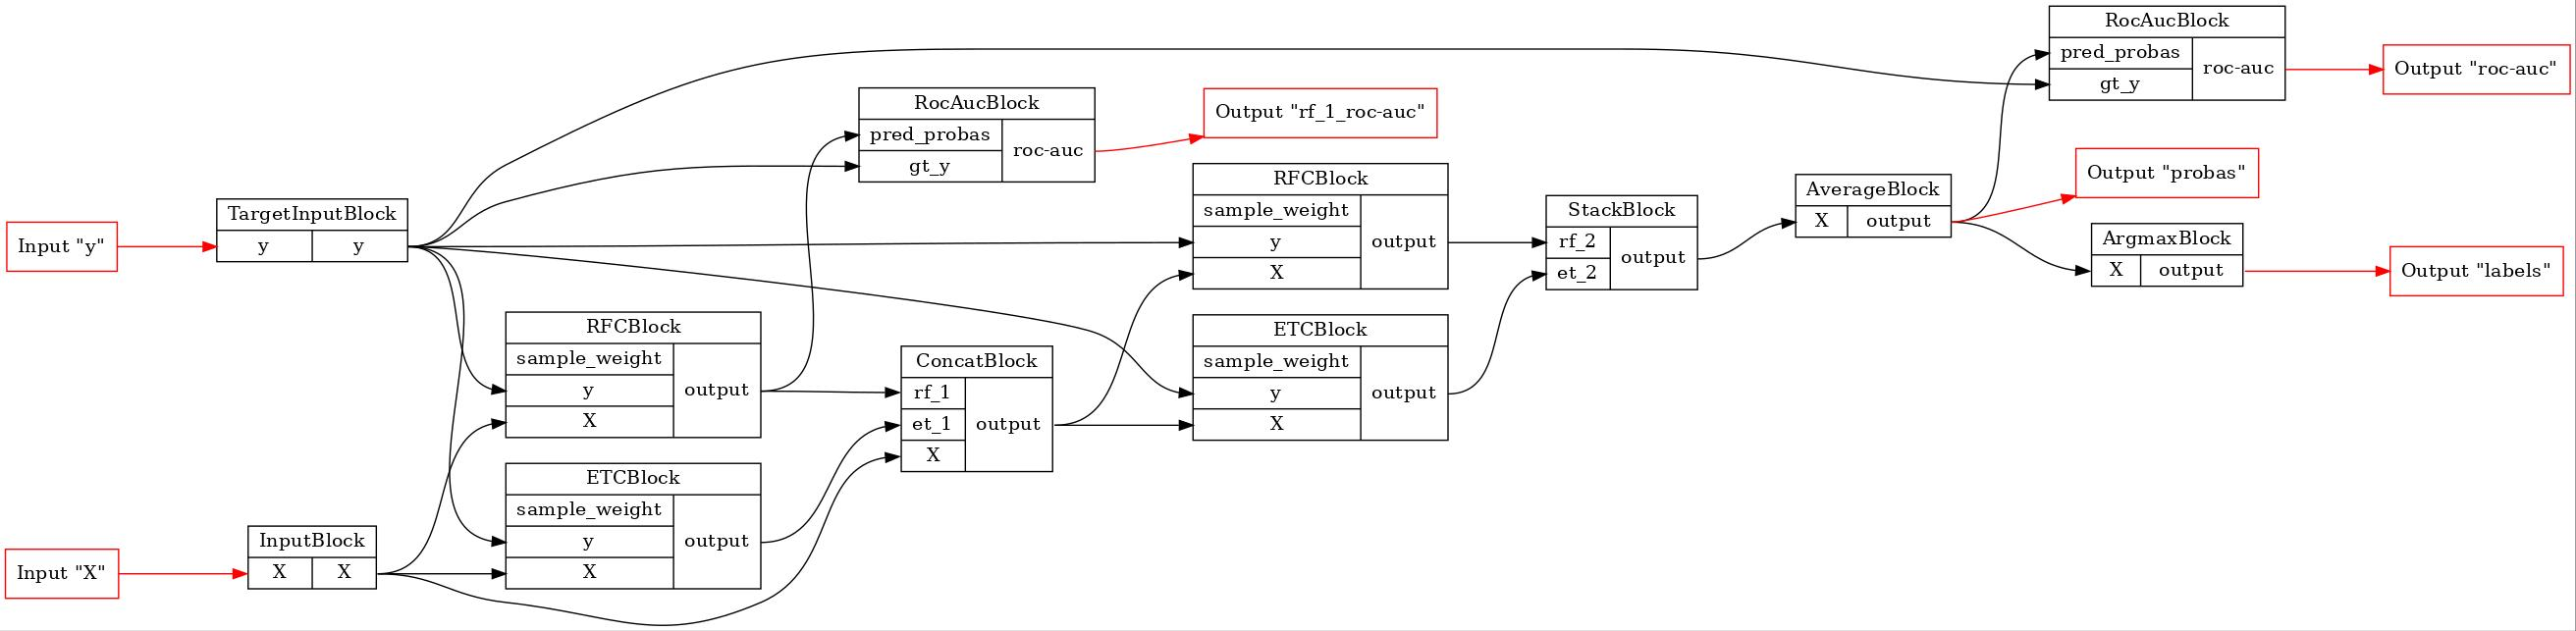

In [5]:
# using manual connections
# firstly we need to create blocks of the pipeline
# we've got input plugs for predictors and labels
input_x = InputBlock()
input_y = TargetInputBlock()
# some deep forest's layers with random forests and extra trees classifiers
rf_1 = RFCBlock(n_estimators=n_estimators)
et_1 = ETCBlock(n_estimators=n_estimators)
concat_1 = ConcatBlock(['rf_1', 'et_1', 'X'], axis=1)
rf_2 = RFCBlock(n_estimators=n_estimators)
et_2 = ETCBlock(n_estimators=n_estimators)
stack = StackBlock(['rf_2', 'et_2'], axis=1)
# blocks for results calcalating (probas and classes)
average = AverageBlock(axis=1)
argmax = ArgmaxBlock(axis=1)
# and some metrics: total roc-auc and for the particular random forest
roc_auc = RocAucBlock()
roc_auc_rf_1 = RocAucBlock()
# we need to manually declare our pipeline: set of blocks,
# connections between them, input slots and output ones
pipeline = BasePipeline(
    nodes=[
        input_x,
        input_y,
        rf_1,
        et_1,
        concat_1,
        rf_2,
        et_2,
        stack,
        average,
        argmax,
        roc_auc,
        roc_auc_rf_1
    ],
    connections=[
        # input X
        Connection(input_x.slots.outputs['X'], rf_1.slots.inputs['X']),
        Connection(input_x.slots.outputs['X'], et_1.slots.inputs['X']),
        Connection(input_x.slots.outputs['X'], concat_1.slots.inputs['X']),
        # input y
        Connection(input_y.slots.outputs['y'], rf_1.slots.inputs['y']),
        Connection(input_y.slots.outputs['y'], et_1.slots.inputs['y']),
        Connection(input_y.slots.outputs['y'], rf_2.slots.inputs['y']),
        Connection(input_y.slots.outputs['y'], et_2.slots.inputs['y']),
        # layers connection
        Connection(rf_1.slots.outputs['output'], concat_1.slots.inputs['rf_1']),
        Connection(et_1.slots.outputs['output'], concat_1.slots.inputs['et_1']),
        Connection(concat_1.slots.outputs['output'], rf_2.slots.inputs['X']),
        Connection(concat_1.slots.outputs['output'], et_2.slots.inputs['X']),
        Connection(rf_2.slots.outputs['output'], stack.slots.inputs['rf_2']),
        Connection(et_2.slots.outputs['output'], stack.slots.inputs['et_2']),
        Connection(stack.slots.outputs['output'], average.slots.inputs['X']),
        Connection(average.slots.outputs['output'], argmax.slots.inputs['X']),
        Connection(average.slots.outputs['output'], roc_auc.slots.inputs['pred_probas']),
        Connection(input_y.slots.outputs['y'], roc_auc.slots.inputs['gt_y']),
        Connection(rf_1.slots.outputs['output'], roc_auc_rf_1.slots.inputs['pred_probas']),
        Connection(input_y.slots.outputs['y'], roc_auc_rf_1.slots.inputs['gt_y']),
    ],
    inputs={
        'X': input_x.slots.inputs['X'],
        'y': input_y.slots.inputs['y'],
    },
    outputs={
        'probas': average.slots.outputs['output'],
        'rf_1_roc-auc': roc_auc_rf_1.slots.outputs['roc-auc'],
        'roc-auc': roc_auc.slots.outputs['roc-auc'],
        'labels': argmax.slots.outputs['output']
    }
)
pipeline.set_random_state(random_state)
# let's draw our pipeline to see, what we've got
GraphvizPainter(figure_dpi=100).from_pipeline(pipeline).render('deep_forest.jpeg')
display(Image(filename='deep_forest.jpeg'))

In [6]:
# now let's fit and test our deep forest
# we can define inputs and outputs which we will use
# during execution process. In TopologicalExecutor
# it is not necessary.
fit_executor = EXEC_CLS(
    pipeline,
    stage=Stage.FIT,
    inputs=['X', 'y'],
    outputs=['probas', 'rf_1_roc-auc', 'roc-auc']
)
transform_executor = EXEC_CLS(
    pipeline,
    stage=Stage.TRANSFORM,
    inputs=['X'],
    outputs=['probas', 'labels']
)
train_X, test_X, train_y, test_y = get_plain_dataset()
# To run the executor we must build a dictionary
# with input names as keys and data as values.
# Result of the executor call is a dictionary with
# output names as keys and BaseData as values,
# we shall convert BaseData to a usual numpy array
fit_result = fit_executor({'X': train_X, 'y': train_y}).numpy()
# To fit next layer we must obtain outcomes on the current one,
# thus the fit executor must simply give transformed training data
# on the output. Let's check it
train_result = transform_executor({'X': train_X}).numpy()
print("Fit probas == probas on train:", np.allclose(fit_result['probas'], train_result['probas']))

Fit probas == probas on train: True


In [7]:
# Now let's look at roc-auc scores we've got.
# Obviously, the external score must be the same with the
# obtained during the fit process.
print("Train ROC-AUC:", roc_auc_score(train_y, train_result['probas'][:, 1]))
print(
    "Train ROC-AUC calculated by fit executor:",
    fit_result['roc-auc']
)
print(
    "Train ROC-AUC for RF_1:",
    fit_result['rf_1_roc-auc']
)

Train ROC-AUC: 1.0
Train ROC-AUC calculated by fit executor: 1.0
Train ROC-AUC for RF_1: 0.9892676767676768


In [8]:
# And, finally, we can calculate the roc-auc for the test data
test_result = transform_executor({'X': test_X}).numpy()
print("Test ROC-AUC:", roc_auc_score(test_y, test_result['probas'][:, 1]))

Test ROC-AUC: 0.8571428571428572
